# Rapport interactif

### Sommaire
I. Implémentation sur notre dataset

II. Cas de tests

### Rappel du sujet

Nous essayerons de répondre à la problématique: 
- **Quel est ce monument parisien ?**

À partir de notre dataset.


### Dataset

Nous avons utilisés une extension Chrome qui récupère entre 400 et 500 images à partir d'une recherche, puis nous avons nettoyés certaines images incohérentes. 


### Librairie

Nous avons réalisé **ML**, notre propre librairie de machine learning en C++. Elle dépend de la bibliothèque **Eigen**, qui nous sert à réaliser plus facilement des calculs matriciels.

### Application web

Nous avons décidé de réaliser notre application web en Python en utilisant le micro-framework **Flask** ainsi que **Bootstrap** et **JQuery**

### Étapes de développement

1. Implémentation du perceptron
2. Interopérabilité du perceptron
3. Implémentation du perceptron multi-couches
4. Interopérabilité du perceptron multi-couches
5. Validation sur les cas de tests et correction de la librairie
6. Rédaction de la première version du rapport pour l'étape n°2
7. Création du site web
8. Ajout des fonctionnalités save et load sur le percepetron
9. Interopérabilité du save et du load sur le perceptron
10. Ajout des fonctionnalités save et load sur le perceptron multi-couches
11. Interopérabilité du save et du load sur le perceptron multi-couches
12. Amélioration et finition du site web (*en cours*)
13. Implémentation du Radial Basis Function Network (*en cours*)
14. Rédaction du rapport interactif (*en cours*)
15. Interopérabilité du Radial Basis Function Network (*à venir*)

### Difficultés rencontrées

- Problème d’initialisation des valeurs aléatoires, on avait des modèles tous identiques.
- Tentative d’utiliser std::random_device pour obtenir des valeurs aléatoires plus uniformes. Cela fonctionnait mais on s’est rendus compte que rand() de stdlib suffisait pour notre besoin.
- Confusions due au biais (on a tenté de le supprimer plusieurs fois)
- Erreur d’allocation de mémoire entraînant des erreurs lors du passages des objets par l'interopérabilité
- Destruction d'une instance d'un perceptron multi-couches, mal paramétré entraînant des erreurs lors de l’utilisation de l'interopérabilité.
- Prise en main de NumPy.

# Partie 1. Implémentation sur notre dataset

Dans cette partie, nous montrerons l'étape de pré-traitement des données (*data preprocessing*), puis nous appliquerons notre modéle linéaire ainsi que notre perceptron multi-couches à notre dataset.

## a) Importer le dataset

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from ml import *

Nous définissons les constantes dont nous aurons besoin, tout au long du rapport.

In [2]:
IMG_SIZE = (64, 64)
PATH = os.path.join("data_large/")
TRAIN = os.path.join(PATH, "train")
classes = os.listdir(TRAIN)

In [3]:
print(f"Les différentes classes possibles sont: {', '.join(classes)}")

Les différentes classes possibles sont: moulin-rouge, palais-de-l-elysee, pont-neuf, place-de-la-concorde, jardin-des-tuileries, hotel-de-ville, arc-de-triomphe, musee-d-orsay


In [4]:
def import_images_and_assign_labels(folder, label, X, Y, IMG_SIZE=IMG_SIZE):
    """
    Convertit et redimensionne les images d'un dossier en NumPy Array.
    """
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize(IMG_SIZE)
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (IMG_SIZE[0]* IMG_SIZE[1] * 3,))
        X.append(im_arr)
        Y.append(label)

In [5]:
for s in ["train", "valid", "test"]:
    if s == "test":
        print(f"Nombre d'images dans le {s} set:")
        print(f"{len(os.listdir(os.path.join(PATH, s)))} images.")
    else:
        print(f"Nombre d'images par classes dans le {s} set:")
        res = 0
        for cl in classes:
            print(f"- {cl}: {len(os.listdir(os.path.join(PATH, s, cl)))} images.")
            res+=len(os.listdir(os.path.join(PATH, s, cl)))
        print("Total :", res, "images.")
        print()

Nombre d'images par classes dans le train set:
- moulin-rouge: 391 images.
- palais-de-l-elysee: 441 images.
- pont-neuf: 487 images.
- place-de-la-concorde: 457 images.
- jardin-des-tuileries: 393 images.
- hotel-de-ville: 359 images.
- arc-de-triomphe: 471 images.
- musee-d-orsay: 418 images.
Total : 3417 images.

Nombre d'images par classes dans le valid set:
- moulin-rouge: 129 images.
- palais-de-l-elysee: 129 images.
- pont-neuf: 129 images.
- place-de-la-concorde: 129 images.
- jardin-des-tuileries: 129 images.
- hotel-de-ville: 129 images.
- arc-de-triomphe: 129 images.
- musee-d-orsay: 129 images.
Total : 1032 images.

Nombre d'images dans le test set:
1041 images.


In [6]:
def import_dataset(IMG_SIZE=IMG_SIZE):
    """
    Crée les datasets d'entrainement et de validation
    """
    X_train, y_train, X_valid, y_valid = [], [], [], []
    labels = np.identity(len(os.listdir(TRAIN)))        
    for set_type in ["train", "valid"]:
        for cl, lab in zip(classes, labels):
            if set_type == "train":
                X_set, y_set = X_train, y_train
            else:
                X_set, y_set = X_valid, y_valid
            import_images_and_assign_labels(
                os.path.join(PATH, set_type, cl),
                lab,
                X_set,
                y_set,
                IMG_SIZE
            )                
    
    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_valid) / 255.0, np.array(y_valid))

In [7]:
(X_train, y_train), (X_valid, y_valid) = import_dataset()

In [8]:
def showImg(tensor, label, prediction):
    """
    Affiche une image avec sa prediction et son label
    """
    fig, ax = plt.subplots()
    ax.imshow(tensor.reshape((IMG_SIZE[0], IMG_SIZE[1], 3)))
    ax.set_title(f'Label: {classes[np.argmax(prediction)]}')
    ax.set_xlabel(f'Prediction: {np.argmax(prediction)} / Expected output: {np.argmax(label)}')
    ax.set_xticks([])
    ax.set_yticks([]);
    return ax

254


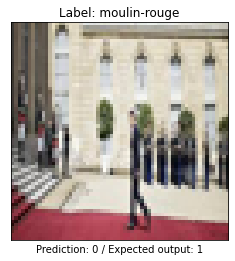

In [9]:
picture_test = np.random.randint(0, len(X_valid)-1)
print(picture_test)
showImg(X_valid[picture_test], y_valid[picture_test], [0, 0, 0]);

## b) Appliquer le modéle linéaire au dataset

Cette section est incomplète.

In [10]:
input_dim = len(X_train[0])

In [11]:
p_model = create_linear_model(input_dim)

In [12]:
picture_test_linear = np.random.randint(0, len(X_train))
test_before = predict_linear_model_classif(p_model, input_dim, X_train[picture_test_linear])
print("Before training:", test_before)

Before training: -1.0


In [13]:
train_linear_classification_model(p_model, input_dim, X_train, y_train.flatten())

In [14]:
test_after = predict_linear_model_classif(p_model, input_dim, X_train[picture_test])
print("After training:", test_after)

After training: -1.0


In [15]:
destroy_linear_model(p_model)

## c) Appliquer le PMC au dataset

Nous allons créer un petit modéle contenant une seule couche cachée puis nous allons l'entraîner pour voir s'il sera capable de prédire correctement une image de la Place de la Concorde, notre image test.

In [16]:
picture_test = 411
input_dim = [len(X_train[0]), 32, 8]

In [17]:
p_model, len_output_layer = create_mlp_model(input_dim)

In [18]:
def accuracy(model):
    """
    Evalue notre modèle sur les données d'entrainement et de validation.
    """
    true_preds = 0
    total_preds = len(X_train)
    for x, y in zip(X_train, y_train):
        if np.argmax(predict_mlp_model_classification(model, x, 8)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy training: {round((true_preds / total_preds) * 100, 2)}%")
    
    true_preds = 0
    total_preds = len(X_valid)
    for x, y in zip(X_valid, y_valid):
        if np.argmax(predict_mlp_model_classification(model, x, 8)) == np.argmax(y):
            true_preds += 1
    print(f"Accuracy valid: {round((true_preds / total_preds) * 100, 2)}%")

Voyons si notre modéle non entrainé arrive à prédire correctement une image aléatoire du valid set. 

Prediction: [-0.99859285, -0.99995404, -0.094652206, 0.42892298, 0.92143565, -0.91744775, -0.9991279, 0.99981564]


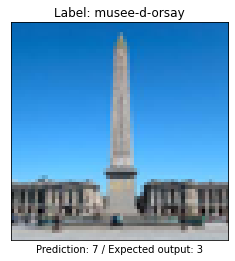

In [19]:
test_before = predict_mlp_model_classification(p_model, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_before);

print("Prediction:", test_before)

In [20]:
#random_idx_train = [np.random.randint(0, len(X_train) - 1) for _ in range(50)]
#random_idx_valid = [np.random.randint(0, len(X_valid) - 1) for _ in range(50)]

In [21]:
#print(f"Indexes aléatoire pour le train set: {random_idx_train}")
#print()
#print(f"Indexes aléatoire pour le valid set: {random_idx_valid}")

Nous pouvons voir que notre modéle prédit correctement le monument environ 1 fois sur 8 (soit 12.5%). Nous avons 8 classes de monuments, ce qui veut dire que nos résultats sont totalement normaux, car notre modèle n'est pas encore entrainé.

In [22]:
accuracy(p_model)

Accuracy training: 13.73%
Accuracy valid: 13.57%


Entraînons désormais notre modéle. Par soucis de temps, nous allons entraîner manuellement un petit modéle de 1000 époques et puis nous chargerons un gros modéle déjà entraîné par nos soins.

In [25]:
train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X_train, y_train.flatten(), epochs=1000)#, alpha=0.01)

Voyons si notre modéle entrainé arrive à prédire correctement une image aléatoire du valid set. 

Prediction: [0.0968812, 0.1544774, 0.16539495, 0.65189546, 0.16723916, 0.10412427, 0.11613728, 0.98431194]


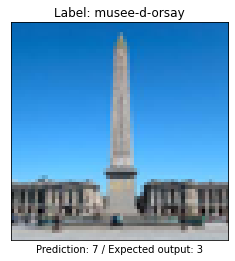

In [26]:
test_after = predict_mlp_model_classification(p_model, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_after);

print("Prediction:", test_after)

Prédiction **correcte** : Etait-ce un coup de chance ou notre modéle réussit désormais à distinguer les différents monuments ? 

Prédiction **incorrecte** : Notre modéle n'as pas réussi à prédire notre image test, as-t-il réellement appris quelque chose durant sa phase d'entraînement ? Notre modéle est potentiellement entrain de **sous-apprendre**.


Pour en avoir le coeur net, voyons comment il s'en sort face à toutes les données du train et du valid set. Nous aurons un meilleur point de vue de son avancé.

In [ ]:
accuracy(p_model)
destroy_mlp_model(p_model)

Prédiction **correcte** : ^^ C'était un coup de chance, pas de bol. Le pourcentage est beaucoup trop faible, notre modéle prédit toujours l'équivalent d'une chance sur 8.

Prédiction **incorrecte** : C'est tout à fait normal, notre modéle n'a pas était assez entraîné.

Passons à la partie intéressante, nous allons charger un modéle pré-entrainé et nous allons effectuer le même test.

Pour commencer, nous allons devoir ré-importer une nouvelle fois les données mais avec une taille d'image différente, nous allons cette fois utiliser des images plus petites (8x8).

In [26]:
IMG_SIZE = (8, 8)

In [27]:
(X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE)

Assurons-nous que les images soit à la bonne dimension.

In [28]:
print("Dimensions des images applatis :", X_train[0].shape)
print("Dimensions souhaités :", (IMG_SIZE[0]*IMG_SIZE[1]*3,))

Dimensions des images applatis : (192,)
Dimensions souhaités : (192,)


Le modéle que nous allons chargé à était entrainé 10 millions d'époques et ne contient aucune couche cachée.

In [29]:
p_model2 = load_mlp_model("models/mlp/MLP_10000000_8x8_8_t_acc-65.5_v_acc-58.04.txt")

Nous y sommes le moment tant attendu est arrivé, est-ce que le modéle entrainé 10 millions d'époques sera capable de prédire notre image selectionné aléatoirement. La suite à la prochaine cellule!

Prediction: [-0.17864059, -0.009236684, -0.1145136, 0.8318115, 0.11925446, 0.108996004, 0.16947888, -0.2370879]


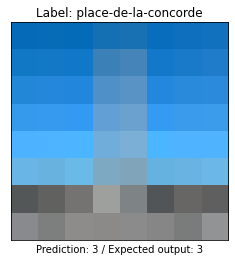

In [30]:
test_load = predict_mlp_model_classification(p_model2, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_load);

print("Prediction:", test_load)

Prédiction **correcte** : FIIIOUUU ! On a pas travaillé 3 mois pour rien ;)

Prédiction **incorrecte** : Voyons sur toutes les données comment notre modéle réagit. (3 mois à la poubelle )-: )

In [31]:
accuracy(p_model2)
destroy_mlp_model(p_model2)

Accuracy training: 65.5%
Accuracy valid: 58.04%


On peut voir que notre modéle pré-entrainé à un peu plus de 1 chance sur 2 de prédire correctement le monument parisien sur des images qu'il n'a jamais vu.

On aurait de meilleures prédictions si nous avons un modéle soit plus gros, soit plus entrainé. Essayons.

In [33]:
p_model3 = load_mlp_model("models/mlp/overfit/MLP_400000_8x8_16_16_16_8_t_acc-95.0_v_acc-31.25.txt")

Prediction: [0.3569752, -0.6451751, 0.71760225, 0.10045294, 0.7974826, -0.118342236, -0.101026, 0.10879318]


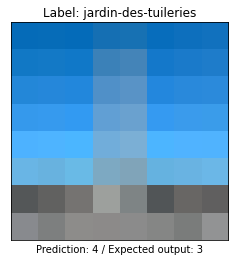

In [34]:
test_p3 = predict_mlp_model_classification(p_model3, X_valid[picture_test], input_dim[-1])

showImg(X_valid[picture_test], y_valid[picture_test], test_p3);

print("Prediction:", test_p3)

In [35]:
accuracy(p_model3)
destroy_mlp_model(p_model3)

Accuracy training: 10.86%
Accuracy valid: 10.27%


----------

CELL DE TEST

In [ ]:
input_dim = [len(X_train[0]), 16, 16, 16, 8]
qp, len_output_layer = create_mlp_model(input_dim)
train_classification_stochastic_gradient_backpropagation_mlp_model(p_model, X_train, y_train.flatten(), epochs=400000)#, alpha=0.01)

In [36]:
save_mlp_model(qp, "models/mlp/overfit/MLP_400000_8x8_16_16_16_8_t_acc-95.0_v_acc-31.25.txt")

In [37]:
p_model4 = load_mlp_model("models/mlp/overfit/MLP_400000_8x8_16_16_16_8_t_acc-95.0_v_acc-31.25.txt")
accuracy(p_model4)

Accuracy training: 64.62%
Accuracy valid: 56.59%


------

## Part IV. Discover new MLP architectures

In [44]:
import random

In [45]:
number_of_hidden_layers = [0, 1]#, 2, 3]
hidden_layers = [8]#, 16, 32]
size_img = [(8, 8)]#, (16, 16), (32, 32)]
EPOCHS = [10000000, 15000000]

In [46]:
def accuracy_grid_search(model, len_output, X_tr, y_tr, X_val, y_val):
    train_total, valid_total = len(X_train), len(X_valid)
    true_preds = 0
    total_preds = len(X_tr)
    for x, y in zip(X_tr, y_tr):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    train_acc = round((true_preds / total_preds) * 100, 2)
    
    true_preds = 0
    total_preds = len(X_val)
    for x, y in zip(X_val, y_val):
        if np.argmax(predict_mlp_model_classification(model, x, len_output)) == np.argmax(y):
            true_preds += 1
    valid_acc = round((true_preds / total_preds) * 100, 2)
    
    return train_acc, valid_acc

In [47]:
max_train_acc, max_val_acc = 0.0, 0.0

for ep in EPOCHS:
    for s in size_img:
        IMG_SIZE = s
        (X_train, y_train), (X_valid, y_valid) = import_dataset(IMG_SIZE=IMG_SIZE)
        input_dim = [len(X_train[0])]
        for n, num_h in enumerate(number_of_hidden_layers):
            h = random.choices(hidden_layers, k=num_h)
            if h:
                input_dim.extend(random.choices(hidden_layers, k=num_h))
            input_dim.append(8)

            model, last_output_layer = create_mlp_model(input_dim)
            train_classification_stochastic_gradient_backpropagation_mlp_model(model, X_train, y_train.flatten(), epochs=ep)

            train_acc, valid_acc = accuracy_grid_search(model, last_output_layer, X_train, y_train, X_valid, y_valid)

            if input_dim[1:-1] == []:
                filename = f"models/mlp/MLP_{ep}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{input_dim[-1]}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"
            else:
                filename = f"models/mlp/MLP_{ep}_{IMG_SIZE[0]}x{IMG_SIZE[1]}_{'_'.join(map(str, input_dim[1:]))}_t_acc-{train_acc}_v_acc-{valid_acc}.txt"

            print(f"Model parameters: epochs={ep}, img_size={IMG_SIZE}, input_dim={input_dim[1:]} -- Train acc: {train_acc}% / Valid_acc: {valid_acc}%")

            if train_acc > max_train_acc:
                max_train_acc = train_acc
                save_mlp_model(model, filename)
            if valid_acc > max_val_acc:
                max_val_acc = valid_acc
                save_mlp_model(model, filename)

            destroy_mlp_model(model)

            input_dim = [len(X_train[0])]

    print(f"Max Train acc: {max_train_acc}% / Max Valid_acc: {max_val_acc}%")


Model parameters: epochs=10000000, img_size=(8, 8), input_dim=[8] -- Train acc: 65.5% / Valid_acc: 58.04%
Model parameters: epochs=10000000, img_size=(8, 8), input_dim=[8, 8] -- Train acc: 52.56% / Valid_acc: 46.12%
Max Train acc: 65.5% / Max Valid_acc: 58.04%
Model parameters: epochs=15000000, img_size=(8, 8), input_dim=[8] -- Train acc: 65.26% / Valid_acc: 57.75%
Model parameters: epochs=15000000, img_size=(8, 8), input_dim=[8, 8] -- Train acc: 44.28% / Valid_acc: 41.28%
Max Train acc: 65.5% / Max Valid_acc: 58.04%


In [18]:
pm = load_mlp_model("models/mlp/MLP_400000_8x8_8_t_acc-57.77_v_acc-52.91.txt")
pm2 = load_mlp_model("models/mlp/MLP_10000000_8x8_8_t_acc-65.5_v_acc-58.04.txt")
accuracy(pm)

accuracy(pm2)

Accuracy training: 57.77%
Accuracy valid: 52.91%
Accuracy training: 65.5%
Accuracy valid: 58.04%
